# Data extraction

## Setup

We need to:

1. Authenticate with Google.
2. Import libraries.
3. Set the `project-id` which will be used for billing query costs. Query costs for this tutorial are typically ~0.01 - 0.05 USD.

In [2]:
# Access data using Google BigQuery.
from google.colab import auth
from google.cloud import bigquery

# the below variables are used throughout the notebook - do not change them!
subject_ids = [10000032, 10001884, 10002223, 10002495, 10002443, 10003400, 10005866]
id_str = ','.join([str(s) for s in subject_ids])

# You only need to authenticate once per session.
auth.authenticate_user()

In [3]:
# Import libraries
from datetime import timedelta
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# below imports are used for pretty pandas dataframes and plots
from IPython.display import display, HTML
%matplotlib inline
plt.style.use('ggplot')

# Set up environment variables
project_id = 'kind-lab'
os.environ["GOOGLE_CLOUD_PROJECT"] = project_id

# Read data from BigQuery into pandas dataframes.
def run_query(query, project_id=project_id):
    return pd.io.gbq.read_gbq(
        query,
        project_id=project_id,
        dialect="standard"
    )

if project_id == 'CHANGE-ME':
  raise ValueError('You must change project_id to your GCP project at the top of this cell.')

# test it works
df = run_query("""
SELECT *
FROM `physionet-data.mimic_core.patients`
WHERE subject_id = 10012853
""")
assert df.shape[0] >= 1, 'unable to query MIMIC!'
display(df)

,subject_id,gender,anchor_age,anchor_year,anchor_year_group,dod
0,10012853,F,91,2175,2014 - 2016,NaT


In [4]:
# the below variables are used throughout the notebook

# itemids linked to chartevents
item_ids = [220052, 220045, 220227, 220050, 220051, 220210, 223762, 227013, 228232, 
            223835, 220546, 220228, 220545, 220615, 225690, 225651, 227467, 227466, 
            220587, 225612, 220621, 227442, 225624, 220635, 220602, 227446, 227429, 
            227468, 227444, 220580, 227443, 224719, 229571]
itemid_str = ','.join([str(s) for s in item_ids])


# itemids linked to labevents
labitem_ids = [50813, 50893, 51288, 50820, 50818, 50802]
labitemid_str = ','.join([str(s) for s in labitem_ids])

# Cohort MIMIC-IV 

In [5]:
# Exclusion columns that we will use to create our cohort
df = run_query(f'''
SELECT ie.subject_id, ie.hadm_id, ie.stay_id
-- DATE_DIFF truncates hour difference so the exlusions are as follows
, CASE WHEN DATE_DIFF(ie.outtime, ie.intime, HOUR) < 10 THEN 1 ELSE 0 END AS exclude_short_stay
, CASE WHEN DATE_DIFF(ie.outtime, ie.intime, HOUR) >= 480 THEN 1 ELSE 0 END AS exclude_long_stay
, CASE WHEN age.anchor_age >= 18 THEN 0 ELSE 1 END AS exclude_non_adult
, CASE WHEN DATE_DIFF(sep.sofa_time, ie.intime, HOUR) < 4 THEN 1 ELSE 0 END AS exclude_early_sepsis
FROM `physionet-data.mimic_icu.icustays` ie
INNER JOIN `physionet-data.mimic_derived.age` age
    ON ie.hadm_id = age.hadm_id
LEFT JOIN `physionet-data.mimic_derived.sepsis3` sep
    ON ie.stay_id = sep.stay_id
''')
display(df)

,subject_id,hadm_id,stay_id,exclude_short_stay,exclude_long_stay,exclude_non_adult,exclude_early_sepsis
0,16233333,20104005,39550370,0,0,0,0
1,18818836,25852913,34879697,0,0,0,0
2,10474526,21021060,30384015,0,0,0,1
3,11245028,27889421,33064307,0,0,0,0
4,19856829,23266513,38811029,0,0,0,0
...,...,...,...,...,...,...,...
76535,16464652,21685914,39045781,0,0,0,1
76536,18451791,28897092,32688519,0,0,0,0
76537,17715495,20406663,38915774,0,0,0,1
76538,14123938,26523563,39332229,0,0,0,0


In [6]:
# Cohort after length of stay exclusions
df_excl_length_stay = df[(df['exclude_long_stay']==0) & (df['exclude_short_stay']==0)]
df_excl_length_stay

,subject_id,hadm_id,stay_id,exclude_short_stay,exclude_long_stay,exclude_non_adult,exclude_early_sepsis
0,16233333,20104005,39550370,0,0,0,0
1,18818836,25852913,34879697,0,0,0,0
2,10474526,21021060,30384015,0,0,0,1
3,11245028,27889421,33064307,0,0,0,0
4,19856829,23266513,38811029,0,0,0,0
...,...,...,...,...,...,...,...
76535,16464652,21685914,39045781,0,0,0,1
76536,18451791,28897092,32688519,0,0,0,0
76537,17715495,20406663,38915774,0,0,0,1
76538,14123938,26523563,39332229,0,0,0,0


In [7]:
# Cohort after development of sepsis early in the ICU stay
df_excl_length_stay_and_early_sepsis = df_excl_length_stay[df_excl_length_stay['exclude_early_sepsis']==0]
df_excl_length_stay_and_early_sepsis

,subject_id,hadm_id,stay_id,exclude_short_stay,exclude_long_stay,exclude_non_adult,exclude_early_sepsis
0,16233333,20104005,39550370,0,0,0,0
1,18818836,25852913,34879697,0,0,0,0
3,11245028,27889421,33064307,0,0,0,0
4,19856829,23266513,38811029,0,0,0,0
5,16006168,22277686,30927169,0,0,0,0
...,...,...,...,...,...,...,...
76533,11027112,29265965,34473473,0,0,0,0
76534,14891600,22868751,37689325,0,0,0,0
76536,18451791,28897092,32688519,0,0,0,0
76538,14123938,26523563,39332229,0,0,0,0


## Chartevents

In [8]:
# Getting our variables our interest which are linked to chartevents following exclusions  

df = run_query(f'''
WITH chartevents_cohort AS
  (
  WITH cohort AS
  (
    SELECT ie.subject_id, 
    ie.hadm_id, 
    ie.stay_id, 
    ie.intime, 
    ie.outtime
    -- DATE_DIFF truncates hour difference
    , DATE_DIFF(ie.outtime, ie.intime, HOUR)+1 AS los
    -- Since 480 is the maximum time in hours where sepsis can be developed in the patient since the period under study is less than 
    -- 20 days I'll use 1000 as a number to identify patients that didn't develop sepsis.
    , IFNULL(DATE_DIFF(sep.sofa_time, ie.intime, HOUR), 1000) AS time_to_sepsis
    , CASE WHEN DATE_DIFF(ie.outtime, ie.intime, HOUR) < 10 THEN 1 ELSE 0 END AS exclude_short_stay
    , CASE WHEN DATE_DIFF(ie.outtime, ie.intime, HOUR) >= 480 THEN 1 ELSE 0 END AS exclude_long_stay
    , CASE WHEN age.anchor_age >= 18 THEN 0 ELSE 1 END AS exclude_non_adult
    , CASE WHEN DATE_DIFF(sep.sofa_time, ie.intime, HOUR) < 4 THEN 1 ELSE 0 END AS exclude_early_sepsis
    FROM `physionet-data.mimic_icu.icustays` ie
    INNER JOIN `physionet-data.mimic_derived.age` age
        ON ie.hadm_id = age.hadm_id
    LEFT JOIN `physionet-data.mimic_derived.sepsis3` sep
        ON ie.stay_id = sep.stay_id
    -- WHERE ie.stay_id = 37464945
  )
  SELECT ct.subject_id, 
  ct.hadm_id,
  ct.stay_id,  
  ct.intime,
  ct.outtime,
  ct.los,
  ct.time_to_sepsis,
  -- We need to follow lifelines data format, this is why we create stop_time
  DATE_DIFF(ce.charttime, ct.intime, HOUR)+1 AS stop_time,
  ce.itemid,
  ce.charttime,
  ci.label,
  ce.value,
  ce.valuenum,
  ce.valueuom,
  ct.exclude_short_stay, 
  ct.exclude_long_stay, 
  ct.exclude_non_adult, 
  ct.exclude_early_sepsis
  FROM cohort ct
  LEFT JOIN `physionet-data.mimic_icu.chartevents`ce
    ON ct.stay_id = ce.stay_id
  LEFT JOIN `physionet-data.mimic_icu.d_items` ci
    ON ce.itemid = ci.itemid
  WHERE ce.itemid IN ({itemid_str})
  AND ct.exclude_early_sepsis = 0
  AND ct.exclude_short_stay = 0 
  AND ct.exclude_long_stay = 0
  AND ct.exclude_non_adult = 0
  ORDER BY ce.charttime
  )

SELECT cc.subject_id, 
cc.hadm_id, 
cc.stay_id,  
cc.intime,
cc.outtime,
cc.los,
cc.time_to_sepsis,
cc.stop_time-1 AS start_time,
cc.stop_time,
-- Since we will create 1-hour bins and sometimes the measurments are taken with more frequency, we need to 
-- get the final measurement within the hour
LAST_VALUE(cc.valuenum) OVER (PARTITION BY cc.stay_id, cc.stop_time ORDER BY cc.label) as last_measurement_hour,
cc.itemid,
cc.charttime,
cc.label,
cc.value,
cc.valuenum,
cc.valueuom,
cc.exclude_short_stay, 
cc.exclude_long_stay, 
cc.exclude_non_adult, 
cc.exclude_early_sepsis
FROM chartevents_cohort cc
-- For some reason there are cases where the charttime is before the intime so I filtered out those cases
WHERE cc.stop_time > 0  
-- We're only interested in patients while they're free of sepsis
AND cc.time_to_sepsis >= cc.stop_time
ORDER BY cc.stop_time
''')

display(df)

,subject_id,hadm_id,stay_id,intime,outtime,los,time_to_sepsis,start_time,stop_time,last_measurement_hour,itemid,charttime,label,value,valuenum,valueuom,exclude_short_stay,exclude_long_stay,exclude_non_adult,exclude_early_sepsis
0,13231630,27381476,38041585,2186-11-04 08:42:24,2186-11-08 21:35:10,110,7,0,1,95.00,220602,2186-11-04 08:08:00,Chloride (serum),95,95.00,mEq/L,0,0,0,0
1,11462863,20184491,38701111,2142-03-08 10:40:00,2142-03-09 16:49:40,31,1000,0,1,76.00,220045,2142-03-08 10:43:00,Heart Rate,76,76.00,bpm,0,0,0,0
2,10550621,26644270,39178232,2172-06-09 19:43:18,2172-06-10 18:24:21,24,1000,0,1,0.01,227429,2172-06-09 19:13:00,Troponin-T,0.01,0.01,ng/mL,0,0,0,0
3,16062529,23636984,39265201,2186-03-24 19:08:32,2186-03-25 14:04:04,20,1000,0,1,65.00,220051,2186-03-24 19:29:00,Arterial Blood Pressure diastolic,65,65.00,mmHg,0,0,0,0
4,11484862,20063772,39346306,2153-10-24 04:20:00,2153-10-25 00:37:51,21,1000,0,1,142.00,220621,2153-10-24 04:22:00,Glucose (serum),142,142.00,mg/dL,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8196995,17350641,24407059,32452165,2145-12-31 03:19:00,2146-01-19 17:32:12,471,1000,469,470,65.00,220045,2146-01-19 16:00:00,Heart Rate,65,65.00,bpm,0,0,0,0
8196996,14719454,24787140,31794625,2166-12-08 19:54:24,2166-12-28 15:17:57,477,1000,470,471,18.00,220210,2166-12-28 09:00:00,Respiratory Rate,18,18.00,insp/min,0,0,0,0
8196997,14719454,24787140,31794625,2166-12-08 19:54:24,2166-12-28 15:17:57,477,1000,473,474,73.00,220045,2166-12-28 12:00:00,Heart Rate,73,73.00,bpm,0,0,0,0
8196998,14719454,24787140,31794625,2166-12-08 19:54:24,2166-12-28 15:17:57,477,1000,473,474,18.00,220210,2166-12-28 12:00:00,Respiratory Rate,18,18.00,insp/min,0,0,0,0


In [9]:
# Pivoting the table to transform it to wide format
base_df = pd.pivot_table(df, index=['stay_id', 'start_time', 'stop_time', 'time_to_sepsis', 'los'], 
                         columns='label', values='last_measurement_hour').reset_index()
base_df

label,stay_id,start_time,stop_time,time_to_sepsis,los,AST,Alkaline Phosphate,Ammonia,Arterial Blood Pressure diastolic,Arterial Blood Pressure mean,...,Inspired O2 Fraction,Magnesium,PAR-Oxygen saturation,PTT,Potassium (serum),Respiratory Rate,Temperature Celsius,Total Bilirubin,Troponin-T,WBC
0,30000153,0,1,1000,40,NaN,NaN,NaN,NaN,NaN,...,100.0,NaN,NaN,NaN,NaN,18.0,NaN,NaN,NaN,NaN
1,30000153,1,2,1000,40,NaN,NaN,NaN,72.0,NaN,...,NaN,NaN,NaN,NaN,NaN,16.0,NaN,NaN,NaN,NaN
2,30000153,2,3,1000,40,NaN,NaN,NaN,61.0,80.0,...,NaN,NaN,NaN,NaN,NaN,16.0,NaN,NaN,NaN,NaN
3,30000153,3,4,1000,40,NaN,NaN,NaN,65.0,84.0,...,50.0,1.5,NaN,25.3,4.4,14.0,NaN,NaN,0.01,17.0
4,30000153,4,5,1000,40,NaN,NaN,NaN,55.0,71.0,...,NaN,NaN,NaN,NaN,NaN,16.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2069001,39999810,105,106,1000,115,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2069002,39999810,106,107,1000,115,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2069003,39999810,108,109,1000,115,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,18.0,NaN,NaN,NaN,NaN
2069004,39999810,110,111,1000,115,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,15.0,NaN,NaN,NaN,NaN


In [10]:
# Creating a column that tells us when did sepsis start developing
base_df['sepsis'] = base_df.apply(lambda x: False if x.time_to_sepsis > x.stop_time else True, axis=1)
base_df

label,stay_id,start_time,stop_time,time_to_sepsis,los,AST,Alkaline Phosphate,Ammonia,Arterial Blood Pressure diastolic,Arterial Blood Pressure mean,...,Magnesium,PAR-Oxygen saturation,PTT,Potassium (serum),Respiratory Rate,Temperature Celsius,Total Bilirubin,Troponin-T,WBC,sepsis
0,30000153,0,1,1000,40,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,18.0,NaN,NaN,NaN,NaN,False
1,30000153,1,2,1000,40,NaN,NaN,NaN,72.0,NaN,...,NaN,NaN,NaN,NaN,16.0,NaN,NaN,NaN,NaN,False
2,30000153,2,3,1000,40,NaN,NaN,NaN,61.0,80.0,...,NaN,NaN,NaN,NaN,16.0,NaN,NaN,NaN,NaN,False
3,30000153,3,4,1000,40,NaN,NaN,NaN,65.0,84.0,...,1.5,NaN,25.3,4.4,14.0,NaN,NaN,0.01,17.0,False
4,30000153,4,5,1000,40,NaN,NaN,NaN,55.0,71.0,...,NaN,NaN,NaN,NaN,16.0,NaN,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2069001,39999810,105,106,1000,115,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2069002,39999810,106,107,1000,115,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2069003,39999810,108,109,1000,115,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,18.0,NaN,NaN,NaN,NaN,False
2069004,39999810,110,111,1000,115,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,15.0,NaN,NaN,NaN,NaN,False


In [11]:
# Creating a different start column to account for the fact that sometimes there is missing information in a particular hour
base_df["start"] = 0
base_df.loc[(base_df['start_time'] > 0) & (base_df['stop_time'].diff() > 0), 'start'] = base_df['stop_time'] - base_df['stop_time'].diff()
base_df

label,stay_id,start_time,stop_time,time_to_sepsis,los,AST,Alkaline Phosphate,Ammonia,Arterial Blood Pressure diastolic,Arterial Blood Pressure mean,...,PAR-Oxygen saturation,PTT,Potassium (serum),Respiratory Rate,Temperature Celsius,Total Bilirubin,Troponin-T,WBC,sepsis,start
0,30000153,0,1,1000,40,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,18.0,NaN,NaN,NaN,NaN,False,0.0
1,30000153,1,2,1000,40,NaN,NaN,NaN,72.0,NaN,...,NaN,NaN,NaN,16.0,NaN,NaN,NaN,NaN,False,1.0
2,30000153,2,3,1000,40,NaN,NaN,NaN,61.0,80.0,...,NaN,NaN,NaN,16.0,NaN,NaN,NaN,NaN,False,2.0
3,30000153,3,4,1000,40,NaN,NaN,NaN,65.0,84.0,...,NaN,25.3,4.4,14.0,NaN,NaN,0.01,17.0,False,3.0
4,30000153,4,5,1000,40,NaN,NaN,NaN,55.0,71.0,...,NaN,NaN,NaN,16.0,NaN,NaN,NaN,NaN,False,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2069001,39999810,105,106,1000,115,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,105.0
2069002,39999810,106,107,1000,115,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,106.0
2069003,39999810,108,109,1000,115,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,18.0,NaN,NaN,NaN,NaN,False,107.0
2069004,39999810,110,111,1000,115,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,15.0,NaN,NaN,NaN,NaN,False,109.0


In [12]:
# Drop non-relevant columns before fitting
final_df = base_df.fillna(base_df.mean()).drop(['time_to_sepsis', 'los', 'start_time'], axis=1).dropna(axis=1)

In [14]:
pip install lifelines

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 349 kB 5.1 MB/s 
     |████████████████████████████████| 68 kB 6.6 MB/s 
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4048 sha256=8f7adeab4fd748cb998892d00c368624cdb02ea637612b6bc113ce2665324772
  Stored in directory: /root/.cache/pip/wheels/9f/01/ee/1331593abb5725ff7d8c1333aee93a50a1c29d6ddda9665c9f
Successfully built autograd-gamma


Iteration 1: norm_delta = 0.06829, step_size = 0.95000, ll = -147540.74229, newton_decrement = 587.74177, seconds_since_start = 14.6
Iteration 2: norm_delta = 0.01005, step_size = 0.95000, ll = -147122.83311, newton_decrement = 13.22024, seconds_since_start = 23.9
Iteration 3: norm_delta = 0.00063, step_size = 0.95000, ll = -147109.58230, newton_decrement = 0.05125, seconds_since_start = 30.5
Iteration 4: norm_delta = 0.00004, step_size = 1.00000, ll = -147109.53108, newton_decrement = 0.00015, seconds_since_start = 37.1
Iteration 5: norm_delta = 0.00000, step_size = 1.00000, ll = -147109.53093, newton_decrement = 0.00000, seconds_since_start = 44.4
Convergence completed after 5 iterations.


<lifelines.CoxTimeVaryingFitter: fitted with 2069006 periods, 53855 subjects, 13912 events>
         event col = 'sepsis'
         penalizer = 0.1
number of subjects = 53855
 number of periods = 2069006
  number of events = 13912
partial log-likelihood = -147109.53
  time fit was run = 2022-08-01 20:16:56 UTC

---
                                    coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                 
AST                                -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
Alkaline Phosphate                  0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
Ammonia                             0.00       1.00       0.00            -0.00             0.01                 1.00                 1.01
Arterial Blood Pressure diastolic  -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
Arterial Blood Pressure mean       -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
Arterial Blood Pressure systolic   -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
Arterial O2 Saturation             -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
BUN                                -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
Brain Natiuretic Peptide (BNP)      0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
C Reactive Protein (CRP)            0.00       1.00       0.00             0.00             0.01                 1.00                 1.01
Chloride (serum)                   -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
Creatinine (serum)                 -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
Direct Bilirubin                    0.02       1.02       0.01            -0.01             0.05                 0.99                 1.05
Fibrinogen                         -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
Glucose (serum)                    -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
HCO3 (serum)                       -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
Heart Rate                          0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
Hematocrit (serum)                 -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
Hemoglobin                         -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
INR                                -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
Inspired O2 Fraction                0.01       1.01       0.00             0.01             0.01                 1.01                 1.01
Magnesium                          -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
PAR-Oxygen saturation              -0.19       0.83       0.08            -0.34            -0.03                 0.71                 0.97
PTT                                -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
Potassium (serum)                  -0.00       1.00       0.00        

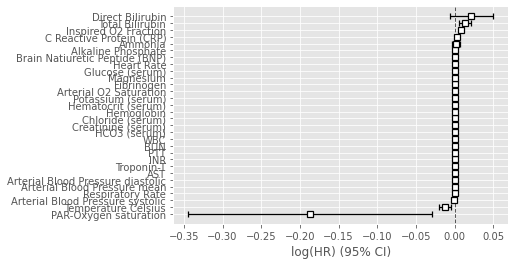

In [15]:
# Fitting the model
import lifelines
from lifelines import CoxTimeVaryingFitter
ctv = CoxTimeVaryingFitter(penalizer=0.1)
ctv.fit(final_df, id_col="stay_id", event_col="sepsis", start_col="start", stop_col="stop_time", show_progress=True)
ctv.print_summary()
ctv.plot()

In [16]:
# We compare the existing model (with all the covariates) to the trivial model of no covariates using the likelihood ratio test.
ctv.log_likelihood_ratio_test()

<lifelines.StatisticalResult: None>
  degrees_freedom = 30
null_distribution = chi squared
        test_name = None

---
                           test_statistic      p  -log2(p)
log-likelihood ratio test          862.42 <0.005    535.87

Attempting prediction

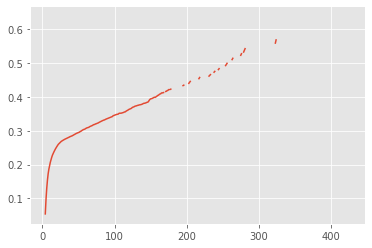

In [19]:
b_hazard = pd.DataFrame({'baseline_hazard': 0}, index = np.arange(1, 480, 1))
b_hazard['baseline_hazard'] = ctv.baseline_cumulative_hazard_
b_hazard['baseline_hazard'].plot()

,baseline_hazard,stop_time
1,0.054309,1
2,0.054309,2
3,0.054309,3
4,0.054309,4
5,0.097317,5
...,...,...
475,0.638915,475
476,0.638915,476
477,0.638915,477
478,0.638915,478


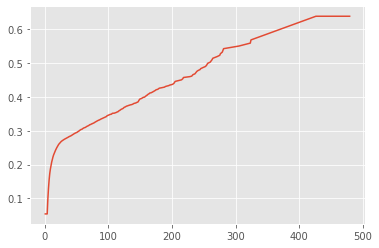

In [20]:
b_hazard = b_hazard.interpolate(method='linear', limit_direction='both', axis=0)
b_hazard['baseline_hazard'].plot()
b_hazard['stop_time'] = b_hazard.index
b_hazard

In [21]:
final_df_predict = final_df.copy()
final_df_predict['partial_hazard'] = ctv.predict_partial_hazard(final_df)
final_df_predict = final_df_predict.merge(b_hazard, left_on='stop_time', right_on='stop_time')
final_df_predict

,stay_id,stop_time,AST,Alkaline Phosphate,Ammonia,Arterial Blood Pressure diastolic,Arterial Blood Pressure mean,Arterial Blood Pressure systolic,Arterial O2 Saturation,BUN,...,Potassium (serum),Respiratory Rate,Temperature Celsius,Total Bilirubin,Troponin-T,WBC,sepsis,start,partial_hazard,baseline_hazard
0,30000153,1,288.519916,116.005081,48.408313,61.060349,80.948181,121.59453,314.801982,113.342843,...,49.447528,18.000000,36.945062,1.918957,81.124586,167.549846,False,0.0,1.489915,0.054309
1,30000213,1,288.519916,116.005081,48.408313,61.060349,80.948181,121.59453,314.801982,113.342843,...,49.447528,22.000000,36.945062,1.918957,81.124586,167.549846,False,0.0,0.985324,0.054309
2,30000646,1,288.519916,116.005081,48.408313,61.060349,80.948181,121.59453,314.801982,113.342843,...,49.447528,28.000000,36.945062,1.918957,81.124586,167.549846,False,0.0,0.998772,0.054309
3,30001336,1,38.000000,281.000000,48.408313,61.060349,80.948181,121.59453,314.801982,17.000000,...,4.200000,30.000000,36.945062,0.900000,1.600000,9.000000,False,0.0,1.121836,0.054309
4,30001656,1,288.519916,116.005081,48.408313,61.060349,80.948181,121.59453,314.801982,113.342843,...,49.447528,16.000000,36.945062,1.918957,81.124586,167.549846,False,0.0,1.490267,0.054309
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2069000,32452165,467,288.519916,116.005081,48.408313,61.060349,80.948181,121.59453,314.801982,113.342843,...,49.447528,16.000000,36.945062,1.918957,81.124586,167.549846,False,466.0,1.000409,0.638915
2069001,38710393,467,288.519916,116.005081,48.408313,61.060349,80.948181,121.59453,314.801982,113.342843,...,49.447528,15.000000,36.945062,1.918957,81.124586,167.549846,False,466.0,1.000545,0.638915
2069002,32452165,468,288.519916,116.005081,48.408313,61.060349,80.948181,121.59453,314.801982,113.342843,...,49.447528,13.000000,36.945062,1.918957,81.124586,167.549846,False,467.0,1.000818,0.638915
2069003,36054435,468,30.000000,86.000000,48.408313,61.060349,80.948181,121.59453,314.801982,53.000000,...,4.600000,18.994809,36.945062,0.700000,81.124586,16.000000,False,343.0,0.961301,0.638915


In [22]:
((final_df_predict['partial_hazard'] * final_df_predict['baseline_hazard']) > 0.5)

0          False
1          False
2          False
3          False
4          False
           ...  
2069000     True
2069001     True
2069002     True
2069003     True
2069004     True
Length: 2069005, dtype: bool

## Labevents

In [23]:
# Getting our variables of interest which are linked to labevents following exclusions  

df = run_query(f'''

WITH labevents_cohort AS
  (
  WITH cohort AS
  (
    SELECT ie.subject_id, 
    ie.hadm_id, 
    ie.stay_id, 
    ie.intime, 
    ie.outtime
    -- DATE_DIFF truncates hour difference
    , DATE_DIFF(ie.outtime, ie.intime, HOUR)+1 AS los
    -- Since 480 is the maximum time in hours where sepsis can be developed in the patient since the period under study is less than 
    -- 20 days I'll use 1000 as a number to identify patients that didn't develop sepsis.
    , IFNULL(DATE_DIFF(sep.sofa_time, ie.intime, HOUR), 1000) AS time_to_sepsis
    , CASE WHEN DATE_DIFF(ie.outtime, ie.intime, HOUR) < 10 THEN 1 ELSE 0 END AS exclude_short_stay
    , CASE WHEN DATE_DIFF(ie.outtime, ie.intime, HOUR) >= 480 THEN 1 ELSE 0 END AS exclude_long_stay
    , CASE WHEN age.anchor_age >= 18 THEN 0 ELSE 1 END AS exclude_non_adult
    , CASE WHEN DATE_DIFF(sep.sofa_time, ie.intime, HOUR) < 4 THEN 1 ELSE 0 END AS exclude_early_sepsis
    FROM `physionet-data.mimic_icu.icustays` ie
    INNER JOIN `physionet-data.mimic_derived.age` age
        ON ie.hadm_id = age.hadm_id
    LEFT JOIN `physionet-data.mimic_derived.sepsis3` sep
        ON ie.stay_id = sep.stay_id
    -- WHERE ie.stay_id = 37464945
  )
  SELECT ct.subject_id, ct.hadm_id, ct.stay_id,  
  ct.intime,
  ct.outtime,
  ct.los,
  ct.time_to_sepsis,
  DATE_DIFF(le.charttime, ct.intime, HOUR)+1 AS stop_time,
  le.itemid,
  le.charttime,
  li.label,
  le.value,
  le.valuenum,
  le.valueuom,
  ct.exclude_short_stay, 
  ct.exclude_long_stay, 
  ct.exclude_non_adult, 
  ct.exclude_early_sepsis
  FROM cohort ct
  LEFT JOIN `physionet-data.mimic_hosp.labevents` le
    ON ct.hadm_id = le.hadm_id
  LEFT JOIN `physionet-data.mimic_hosp.d_labitems` li
    ON le.itemid = li.itemid
  WHERE le.itemid IN ({labitemid_str}) AND ct.intime < le.charttime 
  AND le.charttime < ct.outtime
  AND ct.exclude_early_sepsis = 0
  AND ct.exclude_short_stay = 0 
  AND ct.exclude_long_stay = 0
  AND ct.exclude_non_adult = 0
  ORDER BY le.charttime
  )
SELECT lc.subject_id, 
lc.hadm_id, 
lc.stay_id,  
lc.intime,
lc.outtime,
lc.los,
lc.time_to_sepsis,
lc.stop_time-1 AS start_time,
lc.stop_time,
LAST_VALUE(lc.valuenum) OVER (PARTITION BY lc.stay_id, lc.stop_time ORDER BY lc.label) as last_measurement_hour,
lc.itemid,
lc.charttime,
lc.label,
lc.value,
lc.valuenum,
lc.valueuom,
lc.exclude_short_stay, 
lc.exclude_long_stay, 
lc.exclude_non_adult, 
lc.exclude_early_sepsis
FROM labevents_cohort lc
-- For some reason there are cases where the charttime is before the intime so I filtered out those cases
WHERE lc.stop_time > 0  
-- We're only interested in patients while they're free of sepsis
AND lc.time_to_sepsis >= lc.stop_time
ORDER BY lc.stop_time
''')

display(df)

,subject_id,hadm_id,stay_id,intime,outtime,los,time_to_sepsis,start_time,stop_time,last_measurement_hour,itemid,charttime,label,value,valuenum,valueuom,exclude_short_stay,exclude_long_stay,exclude_non_adult,exclude_early_sepsis
0,14868837,21876956,30027980,2188-03-02 12:01:18,2188-03-03 18:11:10,31,5,0,1,2.0,50802,2188-03-02 12:33:00,Base Excess,2,2.0,mEq/L,0,0,0,0
1,14868837,21876956,30027980,2188-03-02 12:01:18,2188-03-03 18:11:10,31,5,0,1,45.0,50818,2188-03-02 12:33:00,pCO2,45,45.0,mm Hg,0,0,0,0
2,14868837,21876956,30027980,2188-03-02 12:01:18,2188-03-03 18:11:10,31,5,0,1,7.4,50820,2188-03-02 12:33:00,pH,7.40,7.4,units,0,0,0,0
3,15254298,27238312,30048200,2120-03-20 04:13:00,2120-03-20 17:44:57,14,1000,0,1,7.9,50893,2120-03-20 04:55:00,"Calcium, Total",7.9,7.9,mg/dL,0,0,0,0
4,16846688,23370796,30050164,2172-07-21 06:15:00,2172-07-21 20:17:48,15,1000,0,1,10.7,50893,2172-07-21 06:40:00,"Calcium, Total",10.7,10.7,mg/dL,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495239,18871818,25258098,36304851,2112-01-22 20:29:00,2112-02-11 02:01:41,463,1000,442,443,8.7,50893,2112-02-10 06:15:00,"Calcium, Total",8.7,8.7,mg/dL,0,0,0,0
495240,14070452,20917927,35726877,2111-03-06 15:24:00,2111-03-25 14:48:06,456,1000,447,448,9.0,50893,2111-03-25 06:20:00,"Calcium, Total",9.0,9.0,mg/dL,0,0,0,0
495241,14841168,27381987,33625183,2135-01-19 21:06:49,2135-02-07 21:12:12,457,1000,451,452,8.1,50893,2135-02-07 16:57:00,"Calcium, Total",8.1,8.1,mg/dL,0,0,0,0
495242,10110948,20994976,38710393,2179-11-26 04:50:00,2179-12-15 17:39:31,470,1000,452,453,8.1,50893,2179-12-15 00:00:00,"Calcium, Total",8.1,8.1,mg/dL,0,0,0,0


In [24]:
# Pivoting the table to transform it to wide format
base_df = pd.pivot_table(df, 
                         index=['stay_id', 'start_time', 'stop_time', 'time_to_sepsis', 'los'], 
                         columns='label', values='last_measurement_hour').reset_index()
base_df

label,stay_id,start_time,stop_time,time_to_sepsis,los,Base Excess,"Calcium, Total",Lactate,Sedimentation Rate,pCO2,pH
0,30000153,1,2,1000,40,-3.0,NaN,1.3,NaN,45.0,7.30
1,30000153,2,3,1000,40,-3.0,NaN,2.1,NaN,45.0,7.30
2,30000153,3,4,1000,40,NaN,7.4,NaN,NaN,NaN,NaN
3,30000153,4,5,1000,40,-4.0,NaN,NaN,NaN,42.0,7.31
4,30000153,15,16,1000,40,NaN,8.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
216438,39999810,6,7,1000,115,NaN,8.7,NaN,NaN,NaN,NaN
216439,39999810,13,14,1000,115,NaN,8.9,NaN,NaN,NaN,NaN
216440,39999810,30,31,1000,115,NaN,8.8,NaN,NaN,NaN,NaN
216441,39999810,54,55,1000,115,NaN,9.1,NaN,NaN,NaN,NaN


In [25]:
# Creating a column that tells us when did sepsis start developing
base_df['sepsis'] = base_df.apply(lambda x: False if x.time_to_sepsis > x.stop_time else True, axis=1)
base_df

label,stay_id,start_time,stop_time,time_to_sepsis,los,Base Excess,"Calcium, Total",Lactate,Sedimentation Rate,pCO2,pH,sepsis
0,30000153,1,2,1000,40,-3.0,NaN,1.3,NaN,45.0,7.30,False
1,30000153,2,3,1000,40,-3.0,NaN,2.1,NaN,45.0,7.30,False
2,30000153,3,4,1000,40,NaN,7.4,NaN,NaN,NaN,NaN,False
3,30000153,4,5,1000,40,-4.0,NaN,NaN,NaN,42.0,7.31,False
4,30000153,15,16,1000,40,NaN,8.0,NaN,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...
216438,39999810,6,7,1000,115,NaN,8.7,NaN,NaN,NaN,NaN,False
216439,39999810,13,14,1000,115,NaN,8.9,NaN,NaN,NaN,NaN,False
216440,39999810,30,31,1000,115,NaN,8.8,NaN,NaN,NaN,NaN,False
216441,39999810,54,55,1000,115,NaN,9.1,NaN,NaN,NaN,NaN,False


In [26]:
# Creating a different start column to account for the fact that sometimes there is missing information in a particular hour
base_df["start"] = 0
base_df.loc[(base_df['start_time'] > 0) & (base_df['stop_time'].diff() > 0), 'start'] = base_df['stop_time'] - base_df['stop_time'].diff()
base_df

label,stay_id,start_time,stop_time,time_to_sepsis,los,Base Excess,"Calcium, Total",Lactate,Sedimentation Rate,pCO2,pH,sepsis,start
0,30000153,1,2,1000,40,-3.0,NaN,1.3,NaN,45.0,7.30,False,0.0
1,30000153,2,3,1000,40,-3.0,NaN,2.1,NaN,45.0,7.30,False,2.0
2,30000153,3,4,1000,40,NaN,7.4,NaN,NaN,NaN,NaN,False,3.0
3,30000153,4,5,1000,40,-4.0,NaN,NaN,NaN,42.0,7.31,False,4.0
4,30000153,15,16,1000,40,NaN,8.0,NaN,NaN,NaN,NaN,False,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
216438,39999810,6,7,1000,115,NaN,8.7,NaN,NaN,NaN,NaN,False,0.0
216439,39999810,13,14,1000,115,NaN,8.9,NaN,NaN,NaN,NaN,False,7.0
216440,39999810,30,31,1000,115,NaN,8.8,NaN,NaN,NaN,NaN,False,14.0
216441,39999810,54,55,1000,115,NaN,9.1,NaN,NaN,NaN,NaN,False,31.0


In [27]:
# Drop non-relevant columns before fitting
final_df = base_df.fillna(base_df.mean()).drop(['time_to_sepsis', 'los', 'start_time'], axis=1).dropna(axis=1)
final_df

label,stay_id,stop_time,Base Excess,"Calcium, Total",Lactate,Sedimentation Rate,pCO2,pH,sepsis,start
0,30000153,2,-3.000000,8.466598,1.300000,51.136232,45.00000,7.300000,False,0.0
1,30000153,3,-3.000000,8.466598,2.100000,51.136232,45.00000,7.300000,False,2.0
2,30000153,4,-0.527634,7.400000,2.376382,51.136232,42.19789,7.377926,False,3.0
3,30000153,5,-4.000000,8.466598,2.376382,51.136232,42.00000,7.310000,False,4.0
4,30000153,16,-0.527634,8.000000,2.376382,51.136232,42.19789,7.377926,False,5.0
...,...,...,...,...,...,...,...,...,...,...
216438,39999810,7,-0.527634,8.700000,2.376382,51.136232,42.19789,7.377926,False,0.0
216439,39999810,14,-0.527634,8.900000,2.376382,51.136232,42.19789,7.377926,False,7.0
216440,39999810,31,-0.527634,8.800000,2.376382,51.136232,42.19789,7.377926,False,14.0
216441,39999810,55,-0.527634,9.100000,2.376382,51.136232,42.19789,7.377926,False,31.0


Iteration 1: norm_delta = 0.07321, step_size = 0.95000, ll = -83606.21290, newton_decrement = 88.85767, seconds_since_start = 0.8
Iteration 2: norm_delta = 0.00315, step_size = 0.95000, ll = -83518.69665, newton_decrement = 0.16583, seconds_since_start = 1.7
Iteration 3: norm_delta = 0.00017, step_size = 0.95000, ll = -83518.53085, newton_decrement = 0.00049, seconds_since_start = 2.6
Iteration 4: norm_delta = 0.00001, step_size = 1.00000, ll = -83518.53036, newton_decrement = 0.00000, seconds_since_start = 3.5
Convergence completed after 4 iterations.


<lifelines.CoxTimeVaryingFitter: fitted with 216443 periods, 50785 subjects, 7993 events>
         event col = 'sepsis'
         penalizer = 0.1
number of subjects = 50785
 number of periods = 216443
  number of events = 7993
partial log-likelihood = -83518.53
  time fit was run = 2022-08-01 20:32:26 UTC

---
                     coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                  
Base Excess         -0.00       1.00       0.00            -0.01            -0.00                 0.99                 1.00
Calcium, Total      -0.10       0.91       0.01            -0.12            -0.08                 0.89                 0.93
Lactate              0.01       1.01       0.01            -0.00             0.02                 1.00                 1.02
Sedimentation Rate   0.00       1.00       0.00            -0.00             0.01                 1.00                 1.01
pCO2                 0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
pH                  -0.70       0.50       0.09            -0.88            -0.51                 0.41                 0.60

                     cmp to      z      p   -log2(p)
covariate                                           
Base Excess            0.00  -2.03   0.04       4.55
Calcium, Total         0.00 -10.14 <0.005      77.78
Lactate                0.00   1.52   0.13       2.96
Sedimentation Rate     0.00   0.57   0.57       0.81
pCO2                   0.00   3.41 <0.005      10.60
pH                     0.00  -7.48 <0.005      43.58
---
Partial AIC = 167049.06
log-likelihood ratio test = 175.37 on 6 df
-log2(p) of ll-ratio test = 114.56

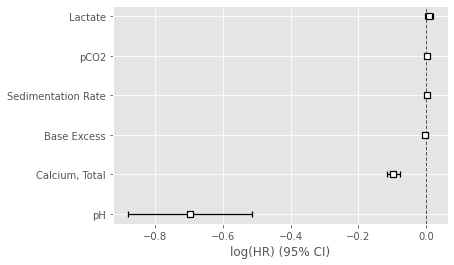

In [28]:
# Fitting the model
ctv = CoxTimeVaryingFitter(penalizer=0.1)
ctv.fit(final_df, id_col="stay_id", event_col="sepsis", start_col="start", stop_col="stop_time", show_progress=True)
ctv.print_summary()
ctv.plot()

In [29]:
# We compare the existing model (with all the covariates) to the trivial model of no covariates using the likelihood ratio test.
ctv.log_likelihood_ratio_test()

<lifelines.StatisticalResult: None>
  degrees_freedom = 6
null_distribution = chi squared
        test_name = None

---
                           test_statistic      p  -log2(p)
log-likelihood ratio test          175.37 <0.005    114.56

Attempting prediction

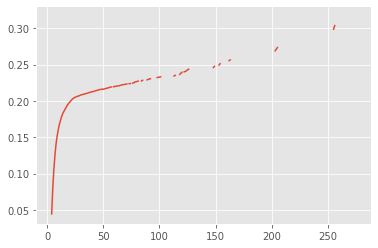

In [30]:
b_hazard = pd.DataFrame({'baseline_hazard': 0}, index = np.arange(1, 480, 1))
b_hazard['baseline_hazard'] = ctv.baseline_cumulative_hazard_
b_hazard['baseline_hazard'].plot()


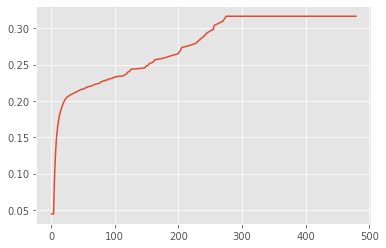

In [31]:
b_hazard = b_hazard.interpolate(method='linear', limit_direction='both', axis=0)
b_hazard['baseline_hazard'].plot()

In [32]:
b_hazard['stop_time'] = b_hazard.index
b_hazard

,baseline_hazard,stop_time
1,0.044546,1
2,0.044546,2
3,0.044546,3
4,0.044546,4
5,0.080337,5
...,...,...
475,0.316463,475
476,0.316463,476
477,0.316463,477
478,0.316463,478


In [33]:
final_df_predict = final_df.copy()
final_df_predict['partial_hazard'] = ctv.predict_partial_hazard(final_df)
final_df_predict = final_df_predict.merge(b_hazard, left_on='stop_time', right_on='stop_time')
final_df_predict

,stay_id,stop_time,Base Excess,"Calcium, Total",Lactate,Sedimentation Rate,pCO2,pH,sepsis,start,partial_hazard,baseline_hazard
0,30000153,2,-3.000000,8.466598,1.300000,51.136232,45.00000,7.300000,False,0.0,1.064201,0.044546
1,30000646,2,-0.527634,7.800000,2.376382,51.136232,42.19789,7.377926,False,0.0,1.066544,0.044546
2,30001148,2,3.000000,8.466598,2.376382,51.136232,38.00000,7.390000,False,0.0,0.967451,0.044546
3,30002548,2,3.000000,8.466598,0.800000,51.136232,44.00000,7.410000,False,0.0,0.957878,0.044546
4,30003275,2,-0.527634,9.100000,2.376382,51.136232,42.19789,7.377926,False,0.0,0.940621,0.044546
...,...,...,...,...,...,...,...,...,...,...,...,...
216438,38710393,409,-0.527634,8.600000,2.376382,51.136232,42.19789,7.377926,False,386.0,0.987190,0.316463
216439,38710393,434,-0.527634,8.100000,2.376382,51.136232,42.19789,7.377926,False,409.0,1.036065,0.316463
216440,38710393,453,-0.527634,8.100000,2.376382,51.136232,42.19789,7.377926,False,434.0,1.036065,0.316463
216441,38761888,359,-0.527634,8.800000,2.376382,51.136232,42.19789,7.377926,False,335.0,0.968292,0.316463


In [34]:
((final_df_predict['partial_hazard'] * final_df_predict['baseline_hazard']) > 0.5).sum()

6

Derived Tables

In [ ]:
df = run_query(f'''
WITH cohort AS
(
  SELECT ie.subject_id, ie.hadm_id, ie.stay_id, ie.intime, ie.outtime, ie.first_careunit, ie.last_careunit
  -- DATE_DIFF truncates hour difference
  , CASE WHEN DATE_DIFF(ie.outtime, ie.intime, HOUR) < 10 THEN 1 ELSE 0 END AS exclude_short_stay
  , CASE WHEN DATE_DIFF(ie.outtime, ie.intime, HOUR) >= 480 THEN 1 ELSE 0 END AS exclude_long_stay
  , CASE WHEN age.anchor_age >= 18 THEN 0 ELSE 1 END AS exclude_non_adult
  , CASE WHEN DATE_DIFF(sep.sofa_time, ie.intime, HOUR) < 4 THEN 1 ELSE 0 END AS exclude_early_sepsis
  FROM `physionet-data.mimic_icu.icustays` ie
  INNER JOIN `physionet-data.mimic_derived.age` age
      ON ie.hadm_id = age.hadm_id
  LEFT JOIN `physionet-data.mimic_derived.sepsis3` sep
      ON ie.stay_id = sep.stay_id
)
SELECT ct.subject_id, ct.hadm_id, ct.stay_id,  
ct.intime,
ct.outtime,
ct.first_careunit,
ct.last_careunit,
da.age,
dc.charlson_comorbidity_index,
ct.exclude_short_stay, ct.exclude_long_stay, ct.exclude_non_adult, ct.exclude_early_sepsis
FROM cohort ct
LEFT JOIN `physionet-data.mimic_derived.age`da
  ON ct.subject_id = da.subject_id
LEFT JOIN `physionet-data.mimic_derived.charlson` dc
  ON ct.subject_id = dc.subject_id
WHERE ct.subject_id = 10002495 
ORDER BY ct.stay_id
''')

display(df)

,subject_id,hadm_id,stay_id,intime,outtime,first_careunit,last_careunit,age,charlson_comorbidity_index,exclude_short_stay,exclude_long_stay,exclude_non_adult,exclude_early_sepsis
0,10002495,24982426,36753294,2141-05-22 20:18:01,2141-05-27 22:24:02,Coronary Care Unit (CCU),Coronary Care Unit (CCU),81,7,0,0,0,1


**Tests**



In [ ]:
ctv.predict_partial_hazard(final_df)

0         1.063318
1         1.070348
2         1.108776
3         1.060102
4         1.046200
            ...   
216437    0.977644
216438    0.958895
216439    0.968224
216440    0.940505
216441    0.958895
Length: 216442, dtype: float64

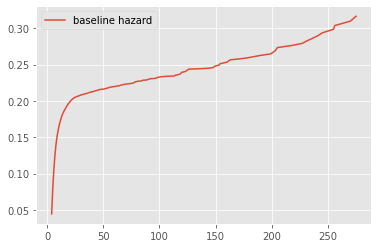

In [ ]:
ctv.baseline_cumulative_hazard_.plot()

In [ ]:
ctv.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
Base Excess,-0.003397,0.996608,0.001709,-0.006748,-0.000047,0.993275,0.999953,0.0,-1.987477,4.686951e-02,4.415206
"Calcium, Total",-0.096820,0.907719,0.009544,-0.115526,-0.078115,0.890898,0.924858,0.0,-10.144936,3.490070e-24,77.923018
Lactate,0.008237,1.008271,0.005520,-0.002583,0.019056,0.997421,1.019239,0.0,1.492132,1.356644e-01,2.881886
Sedimentation Rate,0.001806,1.001808,0.003191,-0.004447,0.008060,0.995563,1.008093,0.0,0.566171,5.712773e-01,0.807737
pCO2,0.002781,1.002785,0.000841,0.001133,0.004429,1.001133,1.004439,0.0,3.306885,9.433953e-04,10.049850
pH,-0.694518,0.499315,0.093419,-0.877616,-0.511419,0.415773,0.599644,0.0,-7.434402,1.050419e-13,43.114100


In [ ]:
ctv.baseline_survival_

,baseline survival
4,0.956428
5,0.922799
6,0.898520
7,0.880821
8,0.867602
...,...
245,0.745523
255,0.741895
256,0.738134
270,0.733632


In [ ]:
ctv.baseline_cumulative_hazard_

,baseline hazard
4,0.044550
5,0.080343
6,0.107006
7,0.126901
8,0.142023
...,...
245,0.293670
255,0.298547
256,0.303630
270,0.309748


In [ ]:
df = run_query(f'''
SELECT ie.subject_id, ie.hadm_id, ie.stay_id, ie.intime, ie.outtime
, (ie.intime - ie.outtime) AS DateDiff
, DATE_DIFF(ie.outtime, ie.intime, HOUR) AS DD
-- DATE_DIFF truncates hour difference
, CASE WHEN DATE_DIFF(ie.outtime, ie.intime, HOUR) < 8 THEN 1 ELSE 0 END AS exclude_short_stay
, CASE WHEN DATE_DIFF(ie.outtime, ie.intime, HOUR) >= 480 THEN 1 ELSE 0 END AS exclude_long_stay
, CASE WHEN age.anchor_age >= 18 THEN 0 ELSE 1 END AS exclude_non_adult
FROM `physionet-data.mimic_icu.icustays` ie
INNER JOIN `physionet-data.mimic_derived.age` age
    ON ie.hadm_id = age.hadm_id
WHERE ie.subject_id IN ({id_str})
''')
display(df)

,subject_id,hadm_id,stay_id,intime,outtime,DateDiff,DD,exclude_short_stay,exclude_long_stay,exclude_non_adult
0,10001884,26184834,37510196,2131-01-11 04:20:05,2131-01-20 08:27:30,0-0 -9 -4:7:25,220,0,0,0
1,10003400,20214994,32128372,2137-02-25 23:37:19,2137-03-10 21:29:36,0-0 -12 -21:52:17,310,0,0,0
2,10003400,23559586,38383343,2137-08-17 17:36:37,2137-09-02 19:17:11,0-0 -16 -1:40:34,386,0,0,0
3,10003400,23559586,34577403,2137-08-10 19:54:51,2137-08-13 17:54:54,0-0 -2 -22:0:3,70,0,0,0
4,10002495,24982426,36753294,2141-05-22 20:18:01,2141-05-27 22:24:02,0-0 -5 -2:6:1,122,0,0,0
5,10005866,20364112,34170353,2149-10-02 12:48:08,2149-10-04 17:48:36,0-0 -2 -5:0:28,53,0,0,0
6,10002223,22494570,39638202,2158-01-15 08:01:49,2158-01-16 15:19:24,0-0 -1 -7:17:35,31,0,0,0
7,10000032,29079034,39553978,2180-07-23 14:00:00,2180-07-23 23:50:47,0-0 0 -9:50:47,9,0,0,0
8,10002443,21329021,35044219,2183-10-18 00:47:00,2183-10-20 18:48:03,0-0 -2 -18:1:3,66,0,0,0


In [ ]:
df = run_query(f'''
SELECT ie.subject_id, ie.hadm_id, ie.stay_id, ie.intime, ie.outtime, sep.sofa_time, sep.sofa_score, sep.sepsis3
, (ie.intime - ie.outtime) AS DateDiff
, DATE_DIFF(ie.outtime, ie.intime, HOUR) AS DD
-- DATE_DIFF truncates hour difference
, CASE WHEN DATE_DIFF(ie.outtime, ie.intime, HOUR) < 10 THEN 1 ELSE 0 END AS exclude_short_stay
, CASE WHEN DATE_DIFF(ie.outtime, ie.intime, HOUR) >= 480 THEN 1 ELSE 0 END AS exclude_long_stay
, CASE WHEN age.anchor_age >= 18 THEN 0 ELSE 1 END AS exclude_non_adult
, DATE_DIFF(sep.sofa_time, ie.intime, HOUR) AS DD
, CASE WHEN DATE_DIFF(sep.sofa_time, ie.intime, HOUR) < 4 THEN 1 ELSE 0 END AS exclude_early_sepsis
FROM `physionet-data.mimic_icu.icustays` ie
INNER JOIN `physionet-data.mimic_derived.age` age
    ON ie.hadm_id = age.hadm_id
LEFT JOIN `physionet-data.mimic_derived.sepsis3` sep
    ON ie.stay_id = sep.stay_id
''')
display(df)

,subject_id,hadm_id,stay_id,intime,outtime,sofa_time,sofa_score,sepsis3,DateDiff,DD,exclude_short_stay,exclude_long_stay,exclude_non_adult,DD_1,exclude_early_sepsis
0,17310431,22485233,37047409,2110-09-06 08:59:33,2110-09-07 23:05:39,2110-09-07 04:00:00,2.0,True,0-0 -1 -14:6:6,39,0,0,0,20.0,0
1,14895375,24753602,30003275,2110-06-28 17:26:48,2110-06-29 14:10:52,2110-06-29 05:00:00,2.0,True,0-0 0 -20:44:4,21,0,0,0,12.0,0
2,13299333,27282813,39687318,2114-05-29 08:44:18,2114-05-30 22:05:50,2114-05-29 22:00:00,3.0,True,0-0 -1 -13:21:32,38,0,0,0,14.0,0
3,14147585,27195136,33798402,2111-02-19 15:34:46,2111-02-21 18:08:52,2111-02-20 05:00:00,5.0,True,0-0 -2 -2:34:6,51,0,0,0,14.0,0
4,15554295,27705504,39577681,2110-03-09 03:55:00,2110-03-16 18:15:59,2110-03-11 02:00:00,10.0,True,0-0 -7 -14:20:59,183,0,0,0,47.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76535,17866064,28315320,36746030,2196-09-27 08:13:28,2196-09-30 12:37:48,2196-09-27 19:00:00,3.0,True,0-0 -3 -4:24:20,76,0,0,0,11.0,0
76536,19516774,25638763,36663547,2201-12-30 13:46:34,2201-12-31 18:53:38,2201-12-31 00:00:00,2.0,True,0-0 -1 -5:7:4,29,0,0,0,11.0,0
76537,15365753,21499379,39629292,2197-09-08 16:23:00,2197-09-16 21:48:46,2197-09-09 03:00:00,2.0,True,0-0 -8 -5:25:46,197,0,0,0,11.0,0
76538,10800546,28248634,36782769,2198-01-15 19:52:00,2198-01-16 12:36:39,2198-01-16 06:00:00,4.0,True,0-0 0 -16:44:39,17,0,0,0,11.0,0


In [ ]:
df = run_query(f'''
SELECT ie.subject_id, ie.hadm_id, ie.stay_id
-- DATE_DIFF truncates hour difference
, CASE WHEN DATE_DIFF(ie.outtime, ie.intime, HOUR) < 10 THEN 1 ELSE 0 END AS exclude_short_stay
, CASE WHEN DATE_DIFF(ie.outtime, ie.intime, HOUR) >= 480 THEN 1 ELSE 0 END AS exclude_long_stay
, CASE WHEN age.anchor_age >= 18 THEN 0 ELSE 1 END AS exclude_non_adult
, CASE WHEN DATE_DIFF(sep.sofa_time, ie.intime, HOUR) < 4 THEN 1 ELSE 0 END AS exclude_early_sepsis
FROM `physionet-data.mimic_icu.icustays` ie
INNER JOIN `physionet-data.mimic_derived.age` age
    ON ie.hadm_id = age.hadm_id
LEFT JOIN `physionet-data.mimic_derived.sepsis3` sep
    ON ie.stay_id = sep.stay_id
''')
display(df)

,subject_id,hadm_id,stay_id,exclude_short_stay,exclude_long_stay,exclude_non_adult,exclude_early_sepsis
0,16233333,20104005,39550370,0,0,0,0
1,18818836,25852913,34879697,0,0,0,0
2,10474526,21021060,30384015,0,0,0,1
3,11245028,27889421,33064307,0,0,0,0
4,19856829,23266513,38811029,0,0,0,0
...,...,...,...,...,...,...,...
76535,16464652,21685914,39045781,0,0,0,1
76536,18451791,28897092,32688519,0,0,0,0
76537,17715495,20406663,38915774,0,0,0,1
76538,14123938,26523563,39332229,0,0,0,0


In [ ]:
df_excl_length_stay = df[(df['exclude_long_stay']==0) & (df['exclude_short_stay']==0)]
df_excl_length_stay

,subject_id,hadm_id,stay_id,exclude_short_stay,exclude_long_stay,exclude_non_adult,exclude_early_sepsis
0,16233333,20104005,39550370,0,0,0,0
1,18818836,25852913,34879697,0,0,0,0
2,10474526,21021060,30384015,0,0,0,1
3,11245028,27889421,33064307,0,0,0,0
4,19856829,23266513,38811029,0,0,0,0
...,...,...,...,...,...,...,...
76535,16464652,21685914,39045781,0,0,0,1
76536,18451791,28897092,32688519,0,0,0,0
76537,17715495,20406663,38915774,0,0,0,1
76538,14123938,26523563,39332229,0,0,0,0


In [ ]:
df_excl_length_stay_and_early_sepsis = df_excl_length_stay[df_excl_length_stay['exclude_early_sepsis']==0]
df_excl_length_stay_and_early_sepsis

,subject_id,hadm_id,stay_id,exclude_short_stay,exclude_long_stay,exclude_non_adult,exclude_early_sepsis
0,16233333,20104005,39550370,0,0,0,0
1,18818836,25852913,34879697,0,0,0,0
3,11245028,27889421,33064307,0,0,0,0
4,19856829,23266513,38811029,0,0,0,0
5,16006168,22277686,30927169,0,0,0,0
...,...,...,...,...,...,...,...
76533,11027112,29265965,34473473,0,0,0,0
76534,14891600,22868751,37689325,0,0,0,0
76536,18451791,28897092,32688519,0,0,0,0
76538,14123938,26523563,39332229,0,0,0,0


In [ ]:
len(df_excl_length_stay_and_early_sepsis['hadm_id'].unique())

50709

In [ ]:
df[df['exclude_long_stay']==1]

,subject_id,hadm_id,stay_id,exclude_short_stay,exclude_long_stay,exclude_non_adult,exclude_early_sepsis
342,13105864,27810235,37820266,0,1,0,1
346,13337664,26050368,37485420,0,1,0,0
400,16504173,27405913,32144102,0,1,0,0
405,16504173,25082363,35859388,0,1,0,1
412,15983067,24908776,32421408,0,1,0,1
...,...,...,...,...,...,...,...
76344,18775105,21775436,33951736,0,1,0,0
76426,17417573,24710404,36358936,0,1,0,1
76441,11312502,25289892,33521917,0,1,0,1
76495,12648465,22702738,32471162,0,1,0,1


In [ ]:
df[df['exclude_short_stay']==1]

,subject_id,hadm_id,stay_id,intime,outtime,sofa_time,sofa_score,sepsis3,DateDiff,DD,exclude_short_stay,exclude_short_stay_1,exclude_non_adult,DD_1,exclude_early_sepsis
242,10192984,22777564,36933726,2117-10-15 16:08:11,2117-10-16 00:57:37,2117-10-15 16:00:00,4.0,True,0-0 0 -8:49:26,8,1,0,0,0.0,1
1741,15361018,23592768,31324591,2145-02-12 00:50:32,2145-02-12 05:21:02,2145-02-12 00:00:00,3.0,True,0-0 0 -4:30:30,5,1,0,0,0.0,1
2051,13411236,22483382,34784253,2153-06-08 04:00:00,2153-06-08 13:13:17,2153-06-08 04:00:00,2.0,True,0-0 0 -9:13:17,9,1,0,0,0.0,1
3841,19591114,25773196,34571630,2184-07-28 20:12:00,2184-07-29 05:06:30,2184-07-28 20:00:00,2.0,True,0-0 0 -8:54:30,9,1,0,0,0.0,1
4181,18068560,20525607,37635150,2197-08-06 13:12:09,2197-08-06 18:46:40,2197-08-06 13:00:00,4.0,True,0-0 0 -5:34:31,5,1,0,0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73153,14094109,23109693,38886407,2133-03-13 13:14:00,2133-03-13 22:31:43,2133-03-13 20:00:00,2.0,True,0-0 0 -9:17:43,9,1,0,0,7.0,0
73435,18070887,23997562,39982932,2148-01-23 05:54:00,2148-01-23 13:00:44,2148-01-23 12:00:00,3.0,True,0-0 0 -7:6:44,8,1,0,0,7.0,0
74047,18338007,23809077,38201844,2198-08-28 05:47:00,2198-08-28 13:20:37,2198-08-28 12:00:00,2.0,True,0-0 0 -7:33:37,8,1,0,0,7.0,0
74800,13411502,28943160,34436131,2177-05-27 09:59:00,2177-05-27 18:27:07,2177-05-27 17:00:00,2.0,True,0-0 0 -8:28:7,9,1,0,0,8.0,0


In [ ]:
df[df['exclude_early_sepsis']==0]

,subject_id,hadm_id,stay_id,intime,outtime,sofa_time,sofa_score,sepsis3,DateDiff,DD,exclude_short_stay,exclude_short_stay_1,exclude_non_adult,DD_1,exclude_early_sepsis
0,17310431,22485233,37047409,2110-09-06 08:59:33,2110-09-07 23:05:39,2110-09-07 04:00:00,2.0,True,0-0 -1 -14:6:6,39,0,0,0,20.0,0
1,14895375,24753602,30003275,2110-06-28 17:26:48,2110-06-29 14:10:52,2110-06-29 05:00:00,2.0,True,0-0 0 -20:44:4,21,0,0,0,12.0,0
2,13299333,27282813,39687318,2114-05-29 08:44:18,2114-05-30 22:05:50,2114-05-29 22:00:00,3.0,True,0-0 -1 -13:21:32,38,0,0,0,14.0,0
3,14147585,27195136,33798402,2111-02-19 15:34:46,2111-02-21 18:08:52,2111-02-20 05:00:00,5.0,True,0-0 -2 -2:34:6,51,0,0,0,14.0,0
4,15554295,27705504,39577681,2110-03-09 03:55:00,2110-03-16 18:15:59,2110-03-11 02:00:00,10.0,True,0-0 -7 -14:20:59,183,0,0,0,47.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76535,17866064,28315320,36746030,2196-09-27 08:13:28,2196-09-30 12:37:48,2196-09-27 19:00:00,3.0,True,0-0 -3 -4:24:20,76,0,0,0,11.0,0
76536,19516774,25638763,36663547,2201-12-30 13:46:34,2201-12-31 18:53:38,2201-12-31 00:00:00,2.0,True,0-0 -1 -5:7:4,29,0,0,0,11.0,0
76537,15365753,21499379,39629292,2197-09-08 16:23:00,2197-09-16 21:48:46,2197-09-09 03:00:00,2.0,True,0-0 -8 -5:25:46,197,0,0,0,11.0,0
76538,10800546,28248634,36782769,2198-01-15 19:52:00,2198-01-16 12:36:39,2198-01-16 06:00:00,4.0,True,0-0 0 -16:44:39,17,0,0,0,11.0,0


In [ ]:
df = run_query(f'''
SELECT ie.subject_id, ie.hadm_id, ie.stay_id
-- DATE_DIFF truncates hour difference
, CASE WHEN DATE_DIFF(ie.outtime, ie.intime, HOUR) < 10 THEN 1 ELSE 0 END AS exclude_short_stay
, CASE WHEN DATE_DIFF(ie.outtime, ie.intime, HOUR) >= 480 THEN 1 ELSE 0 END AS exclude_long_stay
, CASE WHEN age.anchor_age >= 18 THEN 0 ELSE 1 END AS exclude_non_adult
, CASE WHEN DATE_DIFF(sep.sofa_time, ie.intime, HOUR) < 4 THEN 1 ELSE 0 END AS exclude_early_sepsis
FROM `physionet-data.mimic_icu.icustays` ie
INNER JOIN `physionet-data.mimic_derived.age` age
    ON ie.hadm_id = age.hadm_id
LEFT JOIN `physionet-data.mimic_derived.sepsis3` sep
    ON ie.stay_id = sep.stay_id
''')
display(df)


df = run_query(f'''
WITH rates AS
(
  SELECT DISTINCT a.stay_id, a.first_heart_rate
  , CASE WHEN a.first_heart_rate > 110 THEN 1 ELSE 0 END AS exclude_first_heart_rate
  FROM
  (SELECT ce.subject_id, ce.stay_id, ce.charttime, ce.valuenum
  , FIRST_VALUE(ce.valuenum) OVER (PARTITION BY ce.stay_id ORDER BY ce.charttime) AS first_heart_rate
  FROM `physionet-data.mimic_icu.chartevents` ce
  WHERE ce.subject_id IN ({id_str}) AND ce.itemid = 220045) a
)
SELECT rh.stay_id, rt.first_heart_rate, rt.exclude_first_heart_rate, rh.first_heart_rhythm, rh.exclude_first_heart_rhythm
FROM  (SELECT DISTINCT b.stay_id, b.first_heart_rhythm
      , CASE WHEN b.first_heart_rhythm = "AF (Atrial Fibrillation)" THEN 1 ELSE 0 END AS exclude_first_heart_rhythm
      FROM
      (SELECT ce.subject_id, ce.stay_id, ce.charttime, ce.value
      , FIRST_VALUE(ce.value) OVER (PARTITION BY ce.stay_id ORDER BY ce.charttime) AS first_heart_rhythm
      FROM `physionet-data.mimic_icu.chartevents` ce
      INNER JOIN `physionet-data.mimic_icu.d_items` di
            ON ce.itemid = di.itemid
      WHERE ce.subject_id IN ({id_str}) AND ce.itemid = 220048) b) rh
INNER JOIN rates rt
    ON rt.stay_id = rh.stay_id
''')
display(df)

In [ ]:
# the below variables are used throughout the notebook - do not change them!
subject_ids = [10000032, 10001884, 10002223, 10002495, 10002443, 10003400, 10005866]
id_str = ','.join([str(s) for s in subject_ids])

item_ids = [220052, 220045, 220227, 220050, 220051, 220210, 223762, 227013, 228232, 
            223835, 220546, 220228, 220545, 220615, 225690, 225651, 227467, 227466, 
            220587, 225612, 220621, 227442, 225624, 220635, 220602, 227446, 227429, 
            227468, 227444, 220580, 227443, 224719, 229571]

itemid_str = ','.join([str(s) for s in item_ids])


labitem_ids = [50813, 50893, 51288, 50820, 50818, 50802]

labitemid_str = ','.join([str(s) for s in labitem_ids])

In [ ]:

df = run_query(f'''
WITH cohort AS
(
  SELECT ie.subject_id, ie.hadm_id, ie.stay_id, ie.intime, ie.outtime
  -- DATE_DIFF truncates hour difference
  , CASE WHEN DATE_DIFF(ie.outtime, ie.intime, HOUR) < 10 THEN 1 ELSE 0 END AS exclude_short_stay
  , CASE WHEN DATE_DIFF(ie.outtime, ie.intime, HOUR) >= 480 THEN 1 ELSE 0 END AS exclude_long_stay
  , CASE WHEN age.anchor_age >= 18 THEN 0 ELSE 1 END AS exclude_non_adult
  , CASE WHEN DATE_DIFF(sep.sofa_time, ie.intime, HOUR) < 4 THEN 1 ELSE 0 END AS exclude_early_sepsis
  FROM `physionet-data.mimic_icu.icustays` ie
  INNER JOIN `physionet-data.mimic_derived.age` age
      ON ie.hadm_id = age.hadm_id
  LEFT JOIN `physionet-data.mimic_derived.sepsis3` sep
      ON ie.stay_id = sep.stay_id
)

SELECT ct.subject_id, ct.hadm_id, ct.stay_id,  
ct.intime,
ct.outtime,
ce.itemid,
ce.charttime,
ci.label,
ce.value,
ce.valuenum,
ce.valueuom,
ct.exclude_short_stay, ct.exclude_long_stay, ct.exclude_non_adult, ct.exclude_early_sepsis
FROM cohort ct
LEFT JOIN `physionet-data.mimic_icu.chartevents`ce
  ON ct.stay_id = ce.stay_id
LEFT JOIN `physionet-data.mimic_icu.d_items` ci
  ON ce.itemid = ci.itemid
WHERE ct.subject_id = 10002495 AND ce.itemid IN ({itemid_str}) 
ORDER BY ce.charttime

''')

display(df)

,subject_id,hadm_id,stay_id,intime,outtime,itemid,charttime,label,value,valuenum,valueuom,exclude_short_stay,exclude_long_stay,exclude_non_adult,exclude_early_sepsis
0,10002495,24982426,36753294,2141-05-22 20:18:01,2141-05-27 22:24:02,220210,2141-05-22 20:18:00,Respiratory Rate,26,26.0,insp/min,0,0,0,1
1,10002495,24982426,36753294,2141-05-22 20:18:01,2141-05-27 22:24:02,220045,2141-05-22 20:18:00,Heart Rate,114,114.0,bpm,0,0,0,1
2,10002495,24982426,36753294,2141-05-22 20:18:01,2141-05-27 22:24:02,220210,2141-05-22 20:32:00,Respiratory Rate,26,26.0,insp/min,0,0,0,1
3,10002495,24982426,36753294,2141-05-22 20:18:01,2141-05-27 22:24:02,220045,2141-05-22 20:32:00,Heart Rate,115,115.0,bpm,0,0,0,1
4,10002495,24982426,36753294,2141-05-22 20:18:01,2141-05-27 22:24:02,220045,2141-05-22 21:00:00,Heart Rate,108,108.0,bpm,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567,10002495,24982426,36753294,2141-05-22 20:18:01,2141-05-27 22:24:02,220045,2141-05-27 19:00:00,Heart Rate,85,85.0,bpm,0,0,0,1
568,10002495,24982426,36753294,2141-05-22 20:18:01,2141-05-27 22:24:02,220210,2141-05-27 20:00:00,Respiratory Rate,21,21.0,insp/min,0,0,0,1
569,10002495,24982426,36753294,2141-05-22 20:18:01,2141-05-27 22:24:02,220045,2141-05-27 20:00:00,Heart Rate,86,86.0,bpm,0,0,0,1
570,10002495,24982426,36753294,2141-05-22 20:18:01,2141-05-27 22:24:02,220210,2141-05-27 21:00:00,Respiratory Rate,19,19.0,insp/min,0,0,0,1


In [ ]:

df = run_query(f'''
WITH cohort AS
(
  SELECT ie.subject_id, ie.hadm_id, ie.stay_id, ie.intime, ie.outtime
  -- DATE_DIFF truncates hour difference
  , CASE WHEN DATE_DIFF(ie.outtime, ie.intime, HOUR) < 10 THEN 1 ELSE 0 END AS exclude_short_stay
  , CASE WHEN DATE_DIFF(ie.outtime, ie.intime, HOUR) >= 480 THEN 1 ELSE 0 END AS exclude_long_stay
  , CASE WHEN age.anchor_age >= 18 THEN 0 ELSE 1 END AS exclude_non_adult
  , CASE WHEN DATE_DIFF(sep.sofa_time, ie.intime, HOUR) < 4 THEN 1 ELSE 0 END AS exclude_early_sepsis
  FROM `physionet-data.mimic_icu.icustays` ie
  INNER JOIN `physionet-data.mimic_derived.age` age
      ON ie.hadm_id = age.hadm_id
  LEFT JOIN `physionet-data.mimic_derived.sepsis3` sep
      ON ie.stay_id = sep.stay_id
)

SELECT ct.subject_id, ct.hadm_id, ct.stay_id,  
ct.intime,
ct.outtime,
le.itemid,
le.charttime,
le.value,
le.valuenum,
li.label,
ct.exclude_short_stay, ct.exclude_long_stay, ct.exclude_non_adult, ct.exclude_early_sepsis
FROM cohort ct
LEFT JOIN `physionet-data.mimic_hosp.labevents` le
  ON ct.hadm_id = le.hadm_id
LEFT JOIN `physionet-data.mimic_hosp.d_labitems` li
  ON le.itemid = li.itemid
WHERE le.itemid IN ({labitemid_str}) AND ct.intime < le.charttime AND le.charttime < ct.outtime
ORDER BY le.charttime

''')

display(df)

,subject_id,hadm_id,stay_id,intime,outtime,itemid,charttime,value,valuenum,label,exclude_short_stay,exclude_long_stay,exclude_non_adult,exclude_early_sepsis
0,18106347,24305596,30588857,2110-01-11 10:16:06,2110-01-12 17:17:47,50802,2110-01-11 10:22:00,1,1.00,Base Excess,0,0,0,0
1,18106347,24305596,30588857,2110-01-11 10:16:06,2110-01-12 17:17:47,50818,2110-01-11 10:22:00,47,47.00,pCO2,0,0,0,0
2,18106347,24305596,30588857,2110-01-11 10:16:06,2110-01-12 17:17:47,50820,2110-01-11 10:22:00,7.37,7.37,pH,0,0,0,0
3,18106347,24305596,30588857,2110-01-11 10:16:06,2110-01-12 17:17:47,50818,2110-01-11 11:05:00,41,41.00,pCO2,0,0,0,0
4,18106347,24305596,30588857,2110-01-11 10:16:06,2110-01-12 17:17:47,50820,2110-01-11 11:05:00,7.38,7.38,pH,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1833042,14239401,21199923,35906940,2211-05-01 06:59:19,2211-05-10 22:51:06,50820,2211-05-09 02:48:00,7.49,7.49,pH,0,0,0,0
1833043,14239401,21199923,35906940,2211-05-01 06:59:19,2211-05-10 22:51:06,50802,2211-05-09 02:48:00,9,9.00,Base Excess,0,0,0,0
1833044,14239401,21199923,35906940,2211-05-01 06:59:19,2211-05-10 22:51:06,50818,2211-05-09 02:48:00,44,44.00,pCO2,0,0,0,0
1833045,14239401,21199923,35906940,2211-05-01 06:59:19,2211-05-10 22:51:06,50893,2211-05-10 03:59:00,8.5,8.50,"Calcium, Total",0,0,0,0


In [ ]:

df = run_query(f'''
WITH cohort AS
(
  SELECT ie.subject_id, ie.hadm_id, ie.stay_id, ie.intime, ie.outtime, ie.first_careunit, ie.last_careunit
  -- DATE_DIFF truncates hour difference
  , CASE WHEN DATE_DIFF(ie.outtime, ie.intime, HOUR) < 10 THEN 1 ELSE 0 END AS exclude_short_stay
  , CASE WHEN DATE_DIFF(ie.outtime, ie.intime, HOUR) >= 480 THEN 1 ELSE 0 END AS exclude_long_stay
  , CASE WHEN age.anchor_age >= 18 THEN 0 ELSE 1 END AS exclude_non_adult
  , CASE WHEN DATE_DIFF(sep.sofa_time, ie.intime, HOUR) < 4 THEN 1 ELSE 0 END AS exclude_early_sepsis
  FROM `physionet-data.mimic_icu.icustays` ie
  INNER JOIN `physionet-data.mimic_derived.age` age
      ON ie.hadm_id = age.hadm_id
  LEFT JOIN `physionet-data.mimic_derived.sepsis3` sep
      ON ie.stay_id = sep.stay_id
)
SELECT ct.subject_id, ct.hadm_id, ct.stay_id,  
ct.intime,
ct.outtime,
ct.first_careunit,
ct.last_careunit,
da.age,
dc.charlson_comorbidity_index,
ct.exclude_short_stay, ct.exclude_long_stay, ct.exclude_non_adult, ct.exclude_early_sepsis
FROM cohort ct
LEFT JOIN `physionet-data.mimic_derived.age`da
  ON ct.subject_id = da.subject_id
LEFT JOIN `physionet-data.mimic_derived.charlson` dc
  ON ct.subject_id = dc.subject_id
WHERE ct.subject_id = 10002495 
ORDER BY ct.stay_id
''')

display(df)

,subject_id,hadm_id,stay_id,intime,outtime,first_careunit,last_careunit,age,charlson_comorbidity_index,exclude_short_stay,exclude_long_stay,exclude_non_adult,exclude_early_sepsis
0,10002495,24982426,36753294,2141-05-22 20:18:01,2141-05-27 22:24:02,Coronary Care Unit (CCU),Coronary Care Unit (CCU),81,7,0,0,0,1


In [ ]:
df['label_1'].unique()

array(['Lactate', 'Calcium, Total', 'pCO2', 'Base Excess', 'pH'],
      dtype=object)

In [ ]:
df[df['sofa_score'].isna()]

,subject_id,hadm_id,stay_id,intime,outtime,sofa_time,sofa_score,sepsis3,DateDiff,DD,exclude_short_stay,exclude_short_stay_1,exclude_non_adult
698,16233333,20104005,39550370,2118-09-25 15:52:17,2118-09-26 10:26:18,NaT,NaN,None,0-0 0 -18:34:1,19,1,1,0
699,18818836,25852913,34879697,2110-09-21 11:26:32,2110-09-21 22:41:05,NaT,NaN,None,0-0 0 -11:14:33,11,1,1,0
700,11245028,27889421,33064307,2110-11-12 06:01:00,2110-11-12 18:23:43,NaT,NaN,None,0-0 0 -12:22:43,12,1,1,0
701,19856829,23266513,38811029,2110-12-20 03:42:00,2110-12-20 16:56:04,NaT,NaN,None,0-0 0 -13:14:4,13,1,1,0
702,16006168,22277686,30927169,2110-01-21 05:50:00,2110-01-25 20:59:23,NaT,NaN,None,0-0 -4 -15:9:23,111,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
42444,11027112,29265965,34473473,2206-10-26 00:44:48,2206-10-27 15:32:23,NaT,NaN,None,0-0 -1 -14:47:35,39,1,1,0
42445,14891600,22868751,37689325,2206-02-24 13:40:00,2206-02-25 15:22:09,NaT,NaN,None,0-0 -1 -1:42:9,26,1,1,0
42446,18451791,28897092,32688519,2211-01-05 10:59:50,2211-01-06 17:00:09,NaT,NaN,None,0-0 -1 -6:0:19,31,1,1,0
42447,14123938,26523563,39332229,2208-07-06 08:34:09,2208-07-07 18:33:13,NaT,NaN,None,0-0 -1 -9:59:4,34,1,1,0
